# Team : The Mean Squares

**Student Name :** Jeyasri Subramanian

**Student Id** : 014510132

**Factor**: Neutral micro-patterns of misinformation

In [13]:
import pandas as pd
import numpy as np
import random
import csv
import os
import gensim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
from string import punctuation
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier


from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from scipy import sparse


import matplotlib.pyplot as mp
%matplotlib inline
# Code source: https://degravek.github.io/project-pages/project1/2017/04/28/New-Notebook/
# Dataset from Chakraborty et al. (https://github.com/bhargaviparanjape/clickbait/tree/master/dataset)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Mount Google Drive

In [0]:
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings; warnings.simplefilter('ignore')

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!ls '/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets'

fake.csv  liar_dataset	stopwords.txt  website.csv
glove.6B  News_dataset	toxic.csv


# Load data

In [14]:
true_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/News_dataset/True.csv',low_memory=False,encoding='utf-8')
print(true_data.shape)
true_data.head(5)

(21417, 4)


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [15]:
fake_data = pd.read_csv('/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/News_dataset/Fake.csv',low_memory=False,encoding='utf-8')
print(fake_data.shape)
fake_data.head(5)

(23481, 4)


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


# Include label in data

In [0]:
true_data['label'] = 1
fake_data['label'] = 0

# Concatenate Data

In [0]:
merged_data = pd.concat([true_data, fake_data],ignore_index=True)
merged_data.reset_index()
merged_data.shape

(44898, 5)

In [0]:
merged_data.tail(2)

,title,text,subject,date,label
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0
44897,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016",0


## Data volume check

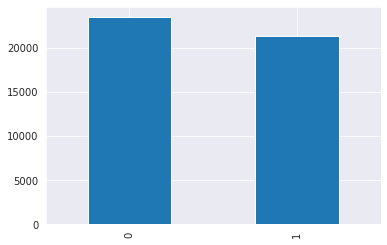

In [0]:
merged_data['label'].value_counts().plot(kind="bar")
plt.show()

# Pre-processing

In [0]:
from gensim import utils
import gensim.parsing.preprocessing as gsp

filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

In [0]:
merged_data['clean_text'] = merged_data['text'].map(lambda x: clean_text(x))
merged_data.head(3)

,title,text,subject,date,label,clean_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...


## Count common words in article

In [0]:
from collections import Counter

aggregate_counter = Counter()
for row_index,row in merged_data.iterrows():
    c = Counter(row['clean_text'].split())
    aggregate_counter += c

common_words = [word[0] for word in aggregate_counter.most_common(50)]
common_words_counts = [word[1] for word in aggregate_counter.most_common(50)]

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

def barplot(words, words_counts, title):
    fig = plt.figure(figsize=(18,6))
    bar_plot = sns.barplot(x=words, y=words_counts)
    for item in bar_plot.get_xticklabels():
        item.set_rotation(90)
    plt.title(title)
    plt.show()

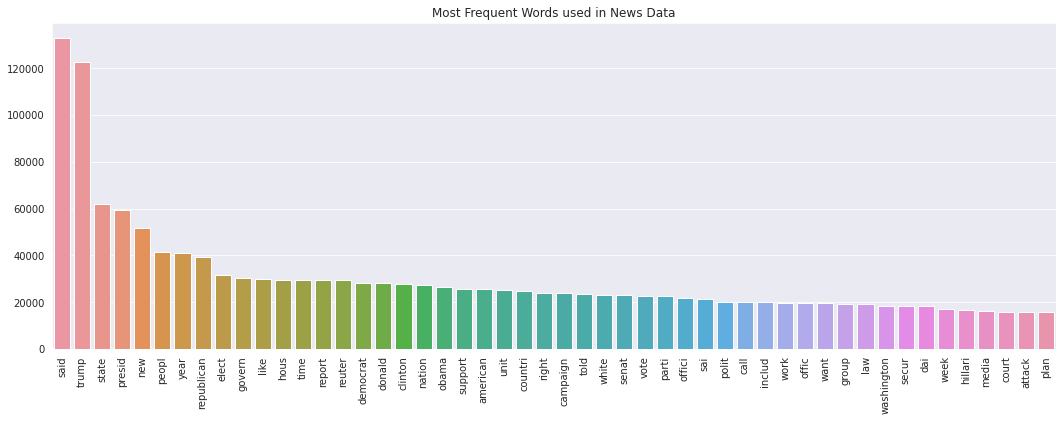

In [0]:
barplot(words=common_words, words_counts=common_words_counts, title='Most Frequent Words used in News Data')

## Uncommon words in News article

In [0]:
from itertools import islice

def key_word_counter(tupple):
    return tupple[1]

all_word_counts = sorted(aggregate_counter.items(), key=key_word_counter)
uncommon_words = [word[0] for word in islice(all_word_counts, 50)]
uncommon_word_counts = [word[1] for word in islice(all_word_counts, 50)]

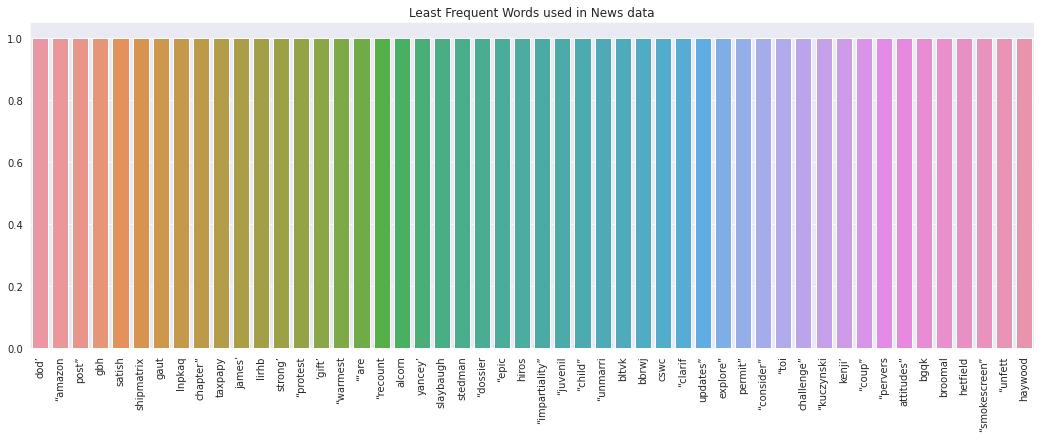

In [0]:
barplot(words=uncommon_words, words_counts=uncommon_word_counts, title='Least Frequent Words used in News data')

## Outlier detection (Anomaly Detection)

In [0]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.parsing.preprocessing import preprocess_string
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20,column='clean_text'):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1
        self.column = column

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(str(row[self.column]).split(), [index]) for index, row in df_x.iterrows()]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(str(row[self.column]).split())
                                     for index, row in df_x.iterrows()]))

In [0]:
#doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vec_tr = Doc2VecTransformer(vector_size=300, learning_rate=0.02, epochs=20,column='clean_text')
doc2vec_tr.fit(merged_data)
doc2vec_vectors = doc2vec_tr.transform(merged_data)

100%|██████████| 44898/44898 [00:00<00:00, 3830282.95it/s]


In [0]:
from sklearn.neural_network import MLPRegressor

# auto_encoder = MLPRegressor(hidden_layer_sizes=(
#                                                  600,
#                                                  150, 
#                                                  600,
#                                                ))


auto_encoder = MLPRegressor(hidden_layer_sizes=(250,100,250),alpha=0.00001, activation='relu', solver='adam',
                      verbose=0)
auto_encoder.fit(doc2vec_vectors, doc2vec_vectors)
predicted_vectors = auto_encoder.predict(doc2vec_vectors)

In [0]:
auto_encoder.score(predicted_vectors, doc2vec_vectors)


0.9644792126274336

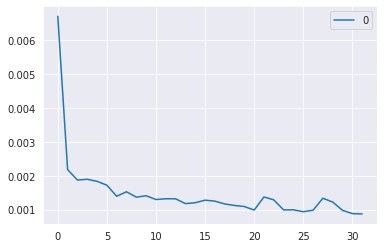

In [0]:
pd.DataFrame(auto_encoder.loss_curve_).plot()


In [0]:
d = {'subject': ['Todays news'], 'statement': ['The President suggested it is the governors fault for not making use of the vast unused testing capacity that exists in their states']}

df = pd.DataFrame(data=d,index=None)
df['clean_text'] = df['statement'].map(lambda x: clean_text(x))

df.head()

,subject,statement,clean_text
0,Todays news,The President suggested it is the governors fa...,presid suggest governor fault make us vast unu...


In [0]:
merged_data.dtypes

title         object
text          object
subject       object
date          object
label          int64
clean_text    object
dtype: object

## Use Cosine similarity for getting outliers

In [0]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(merged_data)
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))
    print('len cosine_similarities : ',len(cosine_similarities))
    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  

        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

In [0]:
len(merged_data)

44898

In [0]:
print('Top 5 unique news')
sorted_cosine_similarities = get_computed_similarities(vectors=doc2vec_vectors, predicted_vectors=predicted_vectors)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Top 5 unique news
len cosine_similarities :  44898
News Title:  New York removes misleading nuclear fallout shelter signs
News statement:  NEW YORK (Reuters) - New York City has quietly begun removing some of the corroding yellow nuclear fallout shelter signs that were appended to thousands of buildings in the 1960s, saying many are misleading Cold War relics that no longer denote functional shelters. The small metal signs are a remnant of the anxieties over the nuclear arms race between the United States and the former Soviet Union, which prompted U.S. President John F. Kennedy to create the shelter program in 1961 in cities across the nation. The signs, with their simple design of three joined triangles inside a circle, became an emblem of the era. While some New Yorkers may barely notice them today, to others they can be an uneasy reminder that the threat may have altered and diminished, but it has not vanished. Although the Cold War era has long ended, North Korea continues working

In [0]:
sim = sorted_cosine_similarities[44892:]
print('Dissimilar News articles')
for i in range(5):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  


        print('Cosine Sim Val :', consine_sim_val)


Dissimilar News articles
News Title:  New York removes misleading nuclear fallout shelter signs
News statement:  NEW YORK (Reuters) - New York City has quietly begun removing some of the corroding yellow nuclear fallout shelter signs that were appended to thousands of buildings in the 1960s, saying many are misleading Cold War relics that no longer denote functional shelters. The small metal signs are a remnant of the anxieties over the nuclear arms race between the United States and the former Soviet Union, which prompted U.S. President John F. Kennedy to create the shelter program in 1961 in cities across the nation. The signs, with their simple design of three joined triangles inside a circle, became an emblem of the era. While some New Yorkers may barely notice them today, to others they can be an uneasy reminder that the threat may have altered and diminished, but it has not vanished. Although the Cold War era has long ended, North Korea continues working to develop nuclear-tipped

In [0]:
merged_data['cosine_similiarity'] = 0.0

## Include similiarity value in dataframe

In [0]:
sim = sorted_cosine_similarities[44892:]

for i in range(0,len(sorted_cosine_similarities)):
        index, consine_sim_val = sorted_cosine_similarities[i]
        merged_data.loc[merged_data.index == index, ['cosine_similiarity']] = consine_sim_val
        if i % 10000 == 0:
          print('Processing ',i ,' of ', len(sorted_cosine_similarities))

Processing  0  of  44898
Processing  10000  of  44898
Processing  20000  of  44898
Processing  30000  of  44898
Processing  40000  of  44898


# Word embeddings and LSTM classification

In [0]:
merged_data.dtypes

title                  object
text                   object
subject                object
date                   object
label                   int64
clean_text             object
cosine_similiarity    float64
dtype: object

In [0]:
x = merged_data['title'] + " " + merged_data['text']
y = pd.get_dummies(merged_data['label'])
#y = np.array(y)

In [0]:
x

0        As U.S. budget fight looms, Republicans flip t...
1        U.S. military to accept transgender recruits o...
2        Senior U.S. Republican senator: 'Let Mr. Muell...
3        FBI Russia probe helped by Australian diplomat...
4        Trump wants Postal Service to charge 'much mor...
                               ...                        
44893    McPain: John McCain Furious That Iran Treated ...
44894    JUSTICE? Yahoo Settles E-mail Privacy Class-ac...
44895    Sunnistan: US and Allied ‘Safe Zone’ Plan to T...
44896    How to Blow $700 Million: Al Jazeera America F...
44897    10 U.S. Navy Sailors Held by Iranian Military ...
Length: 44898, dtype: object

In [0]:
y.head()

,0,1
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [0]:
MAX_NB_WORDS = 100000 # max number of words for tokenizer
MAX_SEQUENCE_LENGTH = 1000 # max length of each sentences, including padding
VALIDATION_SPLIT = 0.2 # 20% of data for validation (not used in training)
EMBEDDING_DIM = 100 # embedding dimensions for word vectors
# GLOVE_DIR = "/content/drive/Shared drives/CMPE 257: Machine Learning/AlterusVera-Datasets/glove/glove.6B."+str(EMBEDDING_DIM)+"d.txt"
GLOVE_DIR = "/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/glove.6B/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [16]:
!ls "/content/drive/My Drive/MLSpring2020/TheMeanSquares-StockPrediction/Alternus-Vera TheMeanSquares/Iteration 1/Datasets/glove.6B/"

glove.6B.100d.txt  glove.6B.200d.txt  glove.6B.300d.txt  glove.6B.50d.txt


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
def clean_text2(text, remove_stopwords = True):
 output = ""
 text = text.lower()
 text = str(text).replace(r'http[\w:/\.]+','') # removing urls
 text = str(text).replace(r'[^\.\w\s]','') #remove everything but characters and punctuation
 text = str(text).replace(r'\.\.+','.') #replace multiple periods with a single one
 text = str(text).replace(r'\.',' . ') #replace periods with a single one
 text = str(text).replace(r'\s\s+',' ') #replace multiple white space with a single one
 text = str(text).replace("\n", "") #removing line breaks
 text = re.sub(r'[^\w\s]','',text).lower() #lower texts
 if remove_stopwords:
  text = text.split(" ")
  
  for word in text:
  
   if word not in stopwords.words("english"):
     output = output + " " + word
     
  #  else:
  #    output = text
 return str(output.strip())[1:-3].replace(" ", " ")

In [0]:
from tqdm import tqdm_notebook
import re
from tqdm import tqdm_notebook
from nltk.corpus import stopwords
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
import pandas as pd
import numpy as np
print(merged_data.shape[0])

44898


Using TensorFlow backend.


In [0]:
l = 'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. “We need to do DACA clean,” she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid. '
b = clean_text(l)
b

'budget fight loom republican flip fiscal script washington reuter head conserv republican faction congress vote month huge expans nation debt pai tax cut call “fiscal conservative” sundai urg budget restraint keep sharp pivot wai republican repres mark meadow speak cbs’ “face nation drew hard line feder spend lawmak brace battl januari return holidai wednesdai lawmak begin try pass feder budget fight like link issu immigr polici novemb congression elect campaign approach republican seek control congress presid donald trump republican want big budget increas militari spend democrat want proport increas non defens “discretionary” spend program support educ scientif research infrastructur public health environment protect “the trump administr will ‘we’r go increas non defens discretionari spend percent meadow chairman small influenti hous freedom caucu said program “now democrat sai that’ need govern pai rais percent fiscal conserv don’t rational eventu run people’ monei said meadow repu

In [0]:

texts = [] 
for line in tqdm_notebook(x, total=merged_data.shape[0]): 
 #print(line) 
 texts.append(clean_text(line))

In [0]:
print('Sample data:', texts[0])


Sample data: budget fight loom republican flip fiscal script washington reuter head conserv republican faction congress vote month huge expans nation debt pai tax cut call “fiscal conservative” sundai urg budget restraint keep sharp pivot wai republican repres mark meadow speak cbs’ “face nation drew hard line feder spend lawmak brace battl januari return holidai wednesdai lawmak begin try pass feder budget fight like link issu immigr polici novemb congression elect campaign approach republican seek control congress presid donald trump republican want big budget increas militari spend democrat want proport increas non defens “discretionary” spend program support educ scientif research infrastructur public health environment protect “the trump administr will ‘we’r go increas non defens discretionari spend percent meadow chairman small influenti hous freedom caucu said program “now democrat sai that’ need govern pai rais percent fiscal conserv don’t rational eventu run people’ monei said

## Tokenizer

In [0]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 107631


## Padding

In [0]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (44898, 1000)
Shape of label tensor: (44898, 2)


## Shuffling

In [0]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
y = np.array(y)

labels = y[indices]

## Split

In [0]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [18735 17184]
validation:  [4746 4233]


In [0]:
#print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

One hot label: 
 [0 1]


## Word Embeddings

In [0]:
embeddings_index = {}
f = open(GLOVE_DIR, encoding='utf8')
print('Loading Glove from:', GLOVE_DIR,'…', end='')
for line in f:
 values = line.split()
 word = values[0]
 embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix…", end="")
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
 embedding_vector = embeddings_index.get(word)
 if embedding_vector is not None:
  embedding_matrix[i] = embedding_vector
print("\n.Completed!")

Loading Glove from: /content/drive/My Drive/dataset/glove.6B/glove.6B.100d.txt …Done.
 Proceeding with Embedding Matrix…
.Completed!


In [0]:
merged_data.dtypes

title                  object
text                   object
subject                object
date                   object
label                   int64
clean_text             object
cosine_similiarity    float64
dtype: object

## LDA Analysis

In [0]:
df_train, df_test = train_test_split(merged_data, test_size=0.2, random_state=0)


### Tf-IDF Modeling

In [0]:
tfidf = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode',
                           analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1,5),
                           use_idf=1, smooth_idf=1, sublinear_tf=1)

X_train_text = tfidf.fit_transform(df_train['text'])
X_test_text  = tfidf.transform(df_test['text'])

In [0]:
X_train_text

<35918x2546028 sparse matrix of type '<class 'numpy.float64'>'
	with 31311462 stored elements in Compressed Sparse Row format>

['trump', 'said', 'president', 'people', 'state', 'new', 'reuters', 'clinton', 'obama', 'donald']


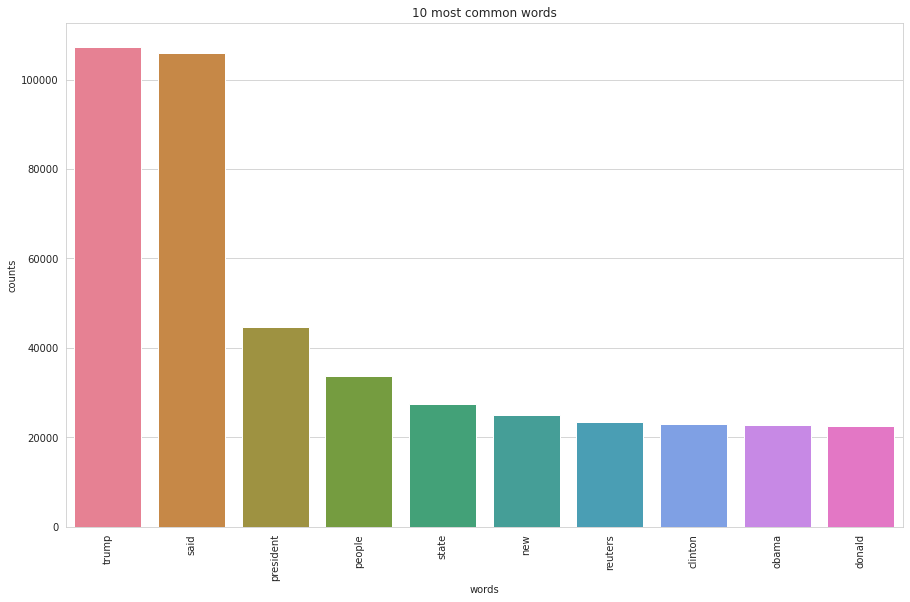

In [0]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    print(words)
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df_train['text'])
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [0]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
said trump russia russian president clinton fbi intelligence investigation news

Topic #1:
trump people just president donald said like twitter white obama

Topic #2:
said reuters united government state president north states china minister

Topic #3:
trump said republican president house senate obama tax republicans reuters

Topic #4:
clinton court state said law people new hillary election police


In [0]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [0]:
merged_data.dtypes

title                  object
text                   object
subject                object
date                   object
label                   int64
clean_text             object
cosine_similiarity    float64
dtype: object

In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
t1 = time.time()
merged_data['tokenized'] = merged_data['text'].apply(apply_all) + merged_data['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(merged_data), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 44898 articles: 5.3115834355354306 min


In [0]:
merged_data

,title,text,subject,date,label,clean_text,cosine_similiarity,tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,0.066262,"[washington, reuter, head, conserv, republican..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,0.062918,"[washington, reuter, transgend, peopl, allow, ..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,0.080726,"[washington, reuter, special, counsel, investi..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,0.092922,"[washington, reuter, trump, campaign, advis, g..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattl washington reuter presid donald trump c...,0.889463,"[seattlewashington, reuter, presid, donald, tr..."
...,...,...,...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0,centuri wire sai wire report earlier week unli...,0.940504,"[st, centuri, wire, say, wire, report, earlier..."
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0,centuri wire sai familiar theme disput chang l...,-0.058011,"[st, centuri, wire, say, familiar, theme, when..."
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0,patrick henningsen centuri wirerememb obama ad...,0.985328,"[patrick, henningsen, st, centuri, wirerememb,..."
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0,centuri wire sai jazeera america histori bigge...,0.072546,"[st, centuri, wire, say, al, jazeera, america,..."


In [0]:
merged_data.to_csv('tokenized_data.csv',index=False)

In [0]:
from gensim import models, corpora, similarities
from gensim.models import LdaModel

def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 10
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(merged_data), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [0]:
dictionary,corpus,lda = train_lda(merged_data)


Time to train LDA model on  44898 articles:  2.372106997172038 min


In [0]:
len(dictionary)

175486

In [0]:
lda.show_topics(num_topics=10, num_words=20)


[(0,
  '0.018*"report" + 0.009*"news" + 0.009*"stori" + 0.009*"media" + 0.008*"case" + 0.008*"offic" + 0.008*"said" + 0.007*"investig" + 0.007*"releas" + 0.007*"offici" + 0.007*"public" + 0.007*"also" + 0.006*"depart" + 0.006*"inform" + 0.006*"secur" + 0.006*"accord" + 0.006*"alleg" + 0.006*"post" + 0.006*"includ" + 0.006*"claim"'),
 (1,
  '0.035*"us" + 0.016*"syria" + 0.014*"state" + 0.013*"war" + 0.010*"militari" + 0.008*"unit" + 0.008*"obama" + 0.008*"countri" + 0.007*"syrian" + 0.007*"presid" + 0.007*"terrorist" + 0.007*"govern" + 0.007*"nation" + 0.007*"world" + 0.006*"said" + 0.006*"forc" + 0.006*"would" + 0.006*"secur" + 0.006*"centuri" + 0.006*"foreign"'),
 (2,
  '0.032*"trump" + 0.011*"presid" + 0.010*"like" + 0.010*"media" + 0.009*"white" + 0.009*"news" + 0.009*"say" + 0.008*"obama" + 0.007*"one" + 0.007*"go" + 0.007*"video" + 0.007*"donald" + 0.007*"time" + 0.007*"get" + 0.006*"even" + 0.006*"peopl" + 0.006*"would" + 0.006*"make" + 0.006*"know" + 0.006*"think"'),
 (3,
  '0.0

In [0]:
#lda.save('/content/drive/My Drive/model2/lda.model')


In [0]:
merged_data.loc[merged_data.index == 0]

,title,text,subject,date,label,clean_text,cosine_similiarity,tokenized
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,0.066262,"[washington, reuter, head, conserv, republican..."


## Add LDA Topics

In [0]:
merged_data['lda_topics'] = ''

In [0]:
def getKey(item):
  return item[1]



corpus = [dictionary.doc2bow(doc) for doc in merged_data['tokenized']]
for i in range(0,len(corpus)):
  list = lda[corpus[i]] # corpus[0] means the first document.
  sorted_list = sorted(list, key=getKey)
  sorted_list.reverse()
  text = " ".join([dictionary[j[0]] for j in sorted_list])
  
  merged_data.loc[merged_data.index == i, ['lda_topics']] = text


In [0]:
merged_data.head()

,title,text,subject,date,label,clean_text,cosine_similiarity,tokenized,lda_topics
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,0.066262,"[washington, reuter, head, conserv, republican...",also alreadi administr approach among aid appr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,0.062918,"[washington, reuter, transgend, peopl, allow, ...",approach add administr action also aid approv ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,0.080726,"[washington, reuter, special, counsel, investi...",agre administr also action add among approv ap...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,0.092922,"[washington, reuter, trump, campaign, advis, g...",agre action add administr among approv approac...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattl washington reuter presid donald trump c...,0.889463,"[seattlewashington, reuter, presid, donald, tr...",alreadi approv action aid administr also appro...


## Compute Cosine similarity

In [0]:
#doc2vec_tr = Doc2VecTransformer(vector_size=300)
doc2vector2 = Doc2VecTransformer(vector_size=150, learning_rate=0.001, epochs=10,column='lda_topics')
doc2vector2.fit(merged_data)
doc2vec_vectors2 = doc2vector2.transform(merged_data)

100%|██████████| 44898/44898 [00:00<00:00, 3518936.02it/s]


In [0]:
from sklearn.neural_network import MLPRegressor

auto_encoder = MLPRegressor(hidden_layer_sizes=(250,100,250),alpha=0.00001, activation='relu', solver='adam',
                      verbose=0)
auto_encoder.fit(doc2vec_vectors2, doc2vec_vectors2)
predicted_vectors2 = auto_encoder.predict(doc2vec_vectors2)

In [0]:
auto_encoder.score(predicted_vectors2, doc2vec_vectors2)


0.9330432799364992

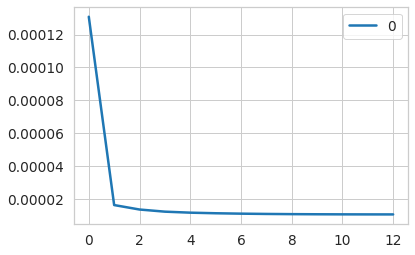

In [0]:
pd.DataFrame(auto_encoder.loss_curve_).plot()


In [0]:
print('Top 5 unique news')
sorted_cosine_similarities2 = get_computed_similarities(vectors=doc2vec_vectors2, predicted_vectors=predicted_vectors2)
display_top_n(sorted_cosine_similarities=sorted_cosine_similarities2)


Top 5 unique news
len cosine_similarities :  44898
News Title:   Twitter Is Working On The Biggest F*ck You To Trump And You’re Going To Love It (DETAILS)
News statement:  Many Americans have been begging Donald Trump to delete his Twitter account for the sake of the country s reputation, and Twitter might have actually found a way to make him quit the social media platform for good!In an effort to combat  fake news , Twitter is developing a feature that will allow its users to flag tweets that contain false or harmful information   which pretty much describes every tweet that Trump posts. Twitter s Vice President of Policy, Colin Crowell, stated that Twitter is working hard to detect spammy behaviors We ve been doubling down on our efforts. This feature is currently in the prototype phase, and is being noted as Twitter s most aggressive attempt yet to maintain the integrity of the content that appears on its platform. According to the Washington Post, this feature would work as a smal

In [0]:
sim = sorted_cosine_similarities[44890:]

for i in range(5):
        index, consine_sim_val = sim[i]
        print('News Title: ', merged_data.iloc[index, 0])  
        print('News statement: ', merged_data.iloc[index, 1])  
        print('News label: ', merged_data.iloc[index, 4])  


        print('Cosine Sim Val :', consine_sim_val)

News Title:  Deputy governor of Afghan province kidnapped in Pakistan
News statement:  ISLAMABAD (Reuters) - Unidentified kidnappers bundled the deputy governor of Afghanistan s northwestern province of Kunar into a car in the Pakistani city of Peshawar and took him away, police sources said on Sunday. Mohammad Nabi Ahmadi had crossed over from Afghanistan into Pakistan with his brother and was walking down a road in the northwestern city of Peshawar when a car with tinted windows pulled up and overpowered the Afghan official, according to a Peshawar police source. The police source said Ahmadi s brother recounted the episode to Pakistani police, but did not disclose that his brother was a high-ranking Afghan provincial government official.  It was afterwards we came to know from other sources that he was deputy governor of Kunar,  said the police official. Abdul Ghani Musamem, the spokesman for the governor of Kunar, confirmed Ahmadi had gone missing in Peshawar on Friday and added th

## Include similairty for LDA topics in dataframe

In [0]:
merged_data['lda_similarity'] = 0.0

In [0]:
sim = sorted_cosine_similarities2[44892:]

for i in range(0,len(sorted_cosine_similarities2)):
  index, consine_sim_val = sorted_cosine_similarities2[i]
  merged_data.loc[merged_data.index == index, ['lda_similarity']] = consine_sim_val
  if i % 500 == 0:
    print('Processing ',index,' of ',len(sorted_cosine_similarities2))


Processing  22367  of  44898
Processing  1461  of  44898
Processing  8291  of  44898
Processing  37022  of  44898
Processing  7714  of  44898
Processing  30850  of  44898
Processing  18207  of  44898
Processing  27787  of  44898
Processing  19437  of  44898
Processing  21821  of  44898
Processing  24095  of  44898
Processing  32029  of  44898
Processing  20547  of  44898
Processing  26243  of  44898
Processing  29666  of  44898
Processing  26092  of  44898
Processing  37  of  44898
Processing  28918  of  44898
Processing  29245  of  44898
Processing  10465  of  44898
Processing  15983  of  44898
Processing  20490  of  44898
Processing  43902  of  44898
Processing  10983  of  44898
Processing  23777  of  44898
Processing  39273  of  44898
Processing  5633  of  44898
Processing  26943  of  44898
Processing  7310  of  44898
Processing  35279  of  44898
Processing  21641  of  44898
Processing  1913  of  44898
Processing  35347  of  44898
Processing  16384  of  44898
Processing  3094  of  4

In [0]:
merged_data.head(4)

,title,text,subject,date,label,clean_text,cosine_similiarity,tokenized,lda_topics,lda_similarity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,0.066262,"[washington, reuter, head, conserv, republican...",also alreadi administr approach among aid appr...,0.347623
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,0.062918,"[washington, reuter, transgend, peopl, allow, ...",approach add administr action also aid approv ...,0.990471
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,0.080726,"[washington, reuter, special, counsel, investi...",agre administr also action add among approv ap...,0.994222
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,0.092922,"[washington, reuter, trump, campaign, advis, g...",agre action add administr among approv approac...,0.994358


In [0]:
tmp = merged_data[['cosine_similiarity','lda_similarity','label']]

In [0]:
tmp

,cosine_similiarity,lda_similarity,label
0,0.066262,0.347623,1
1,0.062918,0.990471,1
2,0.080726,0.994222,1
3,0.092922,0.994358,1
4,0.889463,0.386569,1
...,...,...,...
44893,0.940504,0.869632,0
44894,-0.058011,0.983402,0
44895,0.985328,0.991147,0
44896,0.072546,0.992363,0


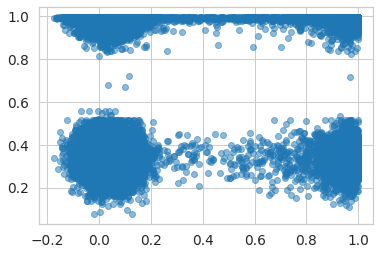

In [0]:
N = 2
np.random.seed(42)
x = merged_data['cosine_similiarity'].values
y = merged_data['lda_similarity'].values
colors = np.random.rand(N)

plt.scatter(x, y, alpha=0.5)
plt.show()

In [0]:
merged_data['average_distance'] = (merged_data['cosine_similiarity'] + merged_data['cosine_similiarity']) /2
merged_data.head()

,title,text,subject,date,label,clean_text,cosine_similiarity,tokenized,lda_topics,lda_similarity,average_distance
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,0.066262,"[washington, reuter, head, conserv, republican...",also alreadi administr approach among aid appr...,0.347623,0.066262
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,0.062918,"[washington, reuter, transgend, peopl, allow, ...",approach add administr action also aid approv ...,0.990471,0.062918
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,0.080726,"[washington, reuter, special, counsel, investi...",agre administr also action add among approv ap...,0.994222,0.080726
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,0.092922,"[washington, reuter, trump, campaign, advis, g...",agre action add administr among approv approac...,0.994358,0.092922
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,seattl washington reuter presid donald trump c...,0.889463,"[seattlewashington, reuter, presid, donald, tr...",alreadi approv action aid administr also appro...,0.386569,0.889463


## Label data

In [0]:
print(min(merged_data['average_distance'] ))
print(max(merged_data['average_distance'] ))
print(np.mean(merged_data['average_distance'] ))

mean_value = np.mean(merged_data['average_distance'] )
merged_data['misinformation'] = 0 

-0.17558505764269428
0.9994732264991406
0.24139435873000417


In [0]:
merged_data['misinformation'] = merged_data['average_distance'].apply(lambda x: 1 if x > mean_value else 0)
merged_data.head(2)

,title,text,subject,date,label,clean_text,cosine_similiarity,tokenized,lda_topics,lda_similarity,average_distance,misinformation
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,0.066262,"[washington, reuter, head, conserv, republican...",also alreadi administr approach among aid appr...,0.347623,0.066262,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow time e...,0.062918,"[washington, reuter, transgend, peopl, allow, ...",approach add administr action also aid approv ...,0.990471,0.062918,0


In [0]:
merged_data.to_csv('data.csv')

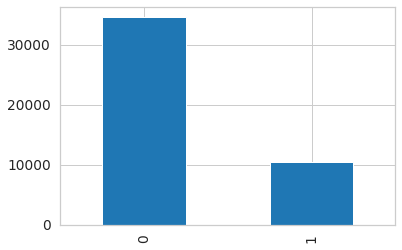

In [0]:
merged_data['misinformation'].value_counts().plot(kind="bar")
plt.show()

(array([0.5, 1.5, 2.5, 3.5, 4.5]), <a list of 5 Text major ticklabel objects>)

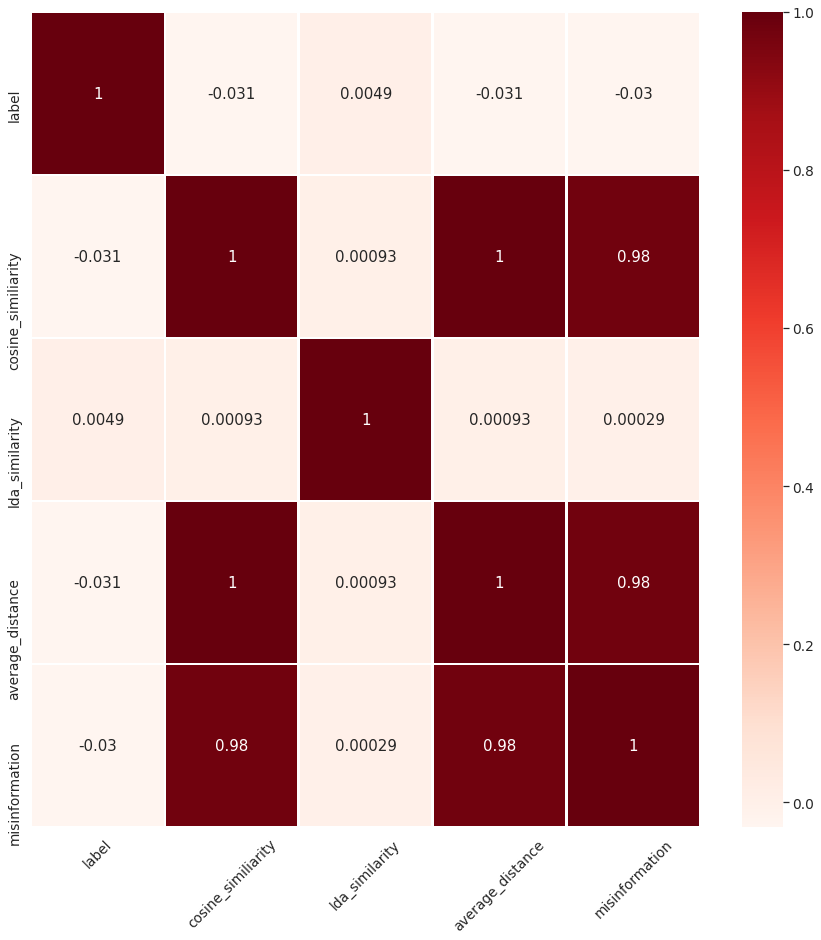

In [0]:
# get the topic contributions for the document chosen at random above
figure, axes = mp.subplots(figsize=(15,15))
sns.heatmap(merged_data.corr(), annot=True, vmax=1, linewidths=1.5, cmap='Reds')
mp.xticks(rotation=45)

## Classification Model

In [0]:
cols = ['cosine_similiarity','lda_similarity','average_distance','label']
y_cols = ['misinformation']

In [0]:
# Prepare data for DT

X = merged_data[cols]
y = merged_data[y_cols]

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [0]:
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [0]:
results = []
names = []

for name, model in models:
    clf = model
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    accu_score = accuracy_score(Y_test, Y_pred)
    print(name + ": " + str(accu_score))

LR: 0.9984409799554566
LDA: 0.9953971789161099
KNN: 0.9998515219005196
CART: 1.0
NB: 0.998218262806236
SVM: 0.9994803266518189
RF: 1.0
XGBoost: 1.0


## LSTM Model Initialization

In [0]:
model = Sequential()
model.add(Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32'))
model.add(Embedding(len(word_index) + 1,
 EMBEDDING_DIM,
 weights = [embedding_matrix],
 input_length = MAX_SEQUENCE_LENGTH,
 trainable=False,
 name = 'embeddings'))
model.add(LSTM(50, return_sequences=True,name='lstm_layer'))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(2, activation="sigmoid"))

### Train model

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy',
 metrics = ['accuracy'])

In [0]:
history = model.fit(x_train, y_train, epochs = 2, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/2
562/562 [==============================] - 28s 50ms/step - loss: 0.3599 - accuracy: 0.8523 - val_loss: 0.0710 - val_accuracy: 0.9684
Epoch 2/2
562/562 [==============================] - 28s 49ms/step - loss: 0.0848 - accuracy: 0.9767 - val_loss: 0.0139 - val_accuracy: 0.9971


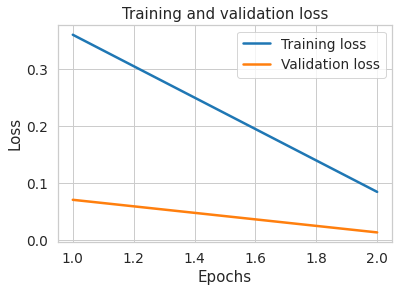

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

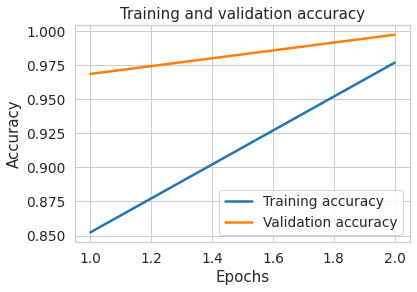

In [0]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Factor Analysis

I have investigated 'Neutral micropatterns of mis-information' pattern. I begin with understanding the micro patterns in the news article and determine how each article varies from other in the corpus by using cosine similarity. 
The descripancies in articles yields anomaly in data and helps to determine the mis-information in the news.

**Design:**

* Preprocess Data
* Doc2Vec 
* LDA for topic modeling 
* Auto Encoder to detect pattern in data
* Determine cosine similarity for preprocessed news article text 
* Determine cosine similarity for LDA topics
* LSTM classifier with Word2Vec



# Data Narrative 

I begun with Liar Liar dataset and Kaggle Fake news dataset as instructed in assignment, but the data has lot of mismatch and I couldn't find enough true label data to proceed further. Hence I have used ISOT news article dataset, which has 21k True labeled data and 23k fake news data.


# Technical Difficulty

* MLPRegressor for encoding is overfitting
* LSTM classifier is overfitting 

The Doc2Vec model tend to memorize, hence the model is overfitting, I am seeing similiar issues reported by other researchers in the area.



# Future Work


* Include more fine-grained features to avoid overfitting
* Include sentence embedding and word2Vec comparison

Resolve the overfitting issue and build a classifier model to determine the misinformation using pattern detection




Reference 
* https://www.searchtechnologies.com/blog/natural-language-processing-techniques
* https://www.analyticsvidhya.com/blog/2019/12/detect-fight-neural-fake-news-nlp/ 
* https://becominghuman.ai/real-vs-fake-tweet-detection-using-a-bert-transformer-model-in-few-lines-of-code-ccc33ecb1a2 
* https://medium.com/@sthacruz/fake-news-classification-using-glove-and-long-short-term-memory-lstm-a48f1dd605ab 
* https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db 
* https://www.kaggle.com/ktattan/lda-and-document-similarity